In [1]:
import os
import pickle
import torch


In [268]:
from datasets import Dataset 
from ragas import evaluate
from ragas.metrics import (answer_relevancy)
from ragas.llms import LangchainLLMWrapper


In [3]:
from langchain_core.pydantic_v1 import BaseModel, Field, validator

### Load Pickle files and Preprocess

#### Define classes for loading pickle file
In case feedback is provided specific Feedback Score class is in value of feedback key under generate_final_answer nodes

In [4]:
class FeedbackScore(BaseModel):
    """Evaluates the quality of an answer with a score from 0 to 100."""

    feedback_score: int = Field(
        default=0,
        ge=0,
        le=100,
        description="Score tussen 0 en 100 bepalend voor de kwaliteit en relevantie van het antwoord gebaseerd op de documenten."
    )

    @validator('feedback_score')
    def check_score_range(cls, value):
        """Ensure the score is within the allowed range."""
        if not (0 <= value <= 100):
            raise ValueError('Score moet tussen 0 en 100 zijn')
        return value

#### Load Data

In [266]:
def load_pkl(folder_path):
    combined_dict = {}
    # Iterate through all files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as f:
                
                data = pickle.load(f)
                
                for ecli, nodes in data.items():
    # Remove 'generate_basic_2' -> not needed for evaluation
                    nodes.pop('generate_basic_2', None)
                    
    # Filter out 'generate' nodes with empty 'documents' key -> no use in evaluation
                    nodes_to_remove = []
                    for node_key, node_value in nodes.items():
                        if 'generate' in node_key and node_value.get('documents') in (None, [], {}):
                            nodes_to_remove.append(node_key)
                    # print(f"Removing {nodes_to_remove} nodes from {ecli}")
                    for node_key in nodes_to_remove:
                        nodes.pop(node_key, None)
                        
    # Merge the data into the combined dictionary
                    if ecli in combined_dict:
                        combined_dict[ecli].update(nodes)
                    else:
                        combined_dict[ecli] = nodes
    
    return combined_dict

In [267]:
combined_results = load_pkl('GPT')

In [256]:
combined_results['ECLI_NL_GHARL_2021_11610'].keys()

dict_keys(['generate_basic_1', 'grade_documents_1', 'generate_1', 'generate_final_answer_1'])

In [257]:
len(combined_results)

1020

In [258]:
# check structure of the combined results 
# and check correct removal of nodes not needed for evaluation
for ecli, nodes in list(combined_results.items()):
    for node_key, node_value in nodes.items():
            # should result in no print statements
            if 'generate' in node_key and node_value.get('documents') is None:
                print(f"  Node: {node_key}, Documents: {node_value.get('documents')}")
            # if 'generate' in node_key and node_value.get('documents') is not None:
            #      print(f"  Node: {node_key}, Documents: {len(node_value.get('documents'))}")
            

In [259]:
combined_results['ECLI_NL_RBZWB_2021_1987'].keys()

dict_keys(['generate_basic_1', 'grade_documents_1', 'generate_1', 'grade_documents_2', 'generate_2', 'generate_final_answer_1'])

#### Subset for feedback improvement

In [299]:
def filter_combined_results(combined_dict):
    filtered_dict = {k: v for k, v in combined_dict.items() 
                     if 'generate_final_answer_1' in v and 'generate_final_answer_2' in v}
    return filtered_dict

In [300]:
fb_subset = filter_combined_results(combined_results)
fb_subset.keys()

dict_keys(['ECLI_NL_RBNHO_2022_10521', 'ECLI_NL_RBAMS_2020_192', 'ECLI_NL_RBROT_2020_11947', 'ECLI_NL_RBZWB_2023_5579', 'ECLI_NL_GHAMS_2022_3650'])

#### Construct evaluation datasets & Metrics

* Create data set per generation node 
* Calculate hit rate on grade_document nodes
* Calculate judge relevacny on presence of feedback in final_answer nodes. If no feedback is present --> LLM has judged answer to be relevant (1)
* Calculate improvement between final_1 relevancy if feedback was present versus final_2 relevancy 

In [260]:


def get_eval_data(results):
    eval_datasets = {
        'generate_basic_1': {'question': [], 'answer': [], 'contexts': []},
        'generate_1': {'question': [], 'answer': [], 'contexts': []},
        'generate_2': {'question': [], 'answer': [], 'contexts': []},
        'generate_final_answer_1': {'question': [], 'answer': [], 'contexts': []},
        'generate_final_answer_2': {'question': [], 'answer': [], 'contexts': []}
    }
    
    for ecli, outputs in results.items():
        for key, output in outputs.items():
             if key in eval_datasets:
                eval_datasets[key]['question'].append(output['question'])
                eval_datasets[key]['answer'].append(output['generation'])
                eval_datasets[key]['contexts'].append([doc for doc in output['documents']])
    
    return eval_datasets


            

In [261]:
data = get_eval_data(combined_results)

In [301]:
data_subset = get_eval_data(fb_subset)

In [262]:
data['generate_final_answer_2'].keys()

dict_keys(['question', 'answer', 'contexts'])

In [364]:
# check lengths to see distribution over the 'generate' nodes
for key in data.keys():
    print(f"{key}, {len(data[key]['question'])}")


generate_basic_1, 1020
generate_1, 969
generate_2, 378
generate_final_answer_1, 950
generate_final_answer_2, 5


In [303]:
# check lengths to see if subset is correct
for key in data_subset.keys():
    print(f"{key}, {len(data_subset[key]['question'])}")

generate_basic_1, 5
generate_1, 5
generate_2, 2
generate_final_answer_1, 5
generate_final_answer_2, 5


In [120]:
metrics = [answer_relevancy]


### GPT 3.5-turbo 0125 Evaluator

In [208]:
os.environ['OPENAI_API_KEY'] = 'YOUR_API_KEY'

In [196]:

from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI

In [209]:
llm_gpt = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0, api_key=os.environ['OPENAI_API_KEY'])
embeddings_gpt = OpenAIEmbeddings(model='text-embedding-3-small')

In [210]:
llm_gpt = LangchainLLMWrapper(llm_gpt)

In [211]:
for m in metrics:
    # change LLM for metric
    m.__setattr__("llm", llm_gpt)

    # check if this metric needs embeddings
    if hasattr(m, "embeddings"):
        # if so change with OpenAI Embeddings
        m.__setattr__("embeddings", embeddings_gpt)

In [ ]:
score_gpt = evaluate(dataset,
                     metrics=metrics,
                     raise_exceptions=False)


In [36]:
score_gpt.to_pandas().to_excel('score_gpt.xlsx')

In [37]:
score_gpt

{'faithfulness': 0.9631, 'answer_relevancy': 0.7608, 'context_relevancy': 0.1051}

In [28]:
score.to_pandas()['contexts'][1]

array(['5.3.6 5.3.7 5.4[medeverdachte 12] – [encrochatnaam 4] @ encrochat .com, [encrochatnaam 11] @encrochat .com en [encrochatnaam 12] @ encrochat .com in het proces- verbaal van bevindingen ‘identificatie encrochat -accounts [medeverdachte 12] ’ 11 en in het proces- verbaal van bevindingen ‘identificatie [encrochatnaam 4] @ encrochat .com, [encrochatnaam 11] @ encrochat .com en [encrochatnaam 12] @ encrochat .com = [medeverdachte 12] ’12 zijn de feiten en omstandigheden opgesomd op grond w aarvan de politie heeft geconcludeerd dat [medeverdachte 12] de gebruik er was van dez e encrochat -accounts. in het eerstgenoemde proces- verbaal is tevens opgenomen dat uit het onderz oek 26t umwater het sterk e vermoeden is ontstaan dat [medeverdachte 12] werkzaam w as voor [medeverdachte 10] en dat zij een direct, nauw contact van elkaar w aren. en ook is daarin opgenomen dat [medeverdachte 12] de bijnaam ‘ [bijnaam 2] ’ had. de verdediging heeft dez e bevindingen en conclusie van de politie n

### Gemini 1.5-PRO Evaluator using VertexAI

In [304]:

from langchain.chat_models import ChatVertexAI
from langchain.embeddings import VertexAIEmbeddings

In [305]:
import google.auth

In [306]:
config = {
    "project_id": "YOUR_PROJECT_ID",
}

# authenticate to GCP
creds, _ = google.auth.default(quota_project_id="YOUR_PROJECT_ID")

In [307]:
import vertexai

In [308]:
vertexai.init(project="YOUR_PROJECT_ID")


In [309]:
llm = ChatVertexAI(temperature=0, model='gemini-pro', credentials=creds)
vertexai_embeddings = VertexAIEmbeddings(credentials=creds)

Model_name will become a required arg for VertexAIEmbeddings starting from Feb-01-2024. Currently the default is set to textembedding-gecko@001


In [310]:
from ragas.llms import LangchainLLMWrapper
ragas_vertexai_llm = LangchainLLMWrapper(llm)

In [311]:
for m in metrics:
    # change LLM for metric
    m.__setattr__("llm", ragas_vertexai_llm)

    # check if this metric needs embeddings
    if hasattr(m, "embeddings"):
        # if so change with VertexAI Embeddings
        m.__setattr__("embeddings", vertexai_embeddings)

In [312]:
print(metrics)

[AnswerRelevancy(embeddings=VertexAIEmbeddings(project=None, location='us-central1', request_parallelism=5, max_retries=6, stop=None, model_name='textembedding-gecko@001', client=<vertexai.language_models.TextEmbeddingModel object at 0x00000192B0167500>, client_preview=None, temperature=0.0, max_output_tokens=128, top_p=0.95, top_k=40, credentials=<google.oauth2.credentials.Credentials object at 0x000001928B8BC5F0>, n=1, streaming=False, instance={'max_batch_size': 250, 'batch_size': 250, 'min_batch_size': 5, 'min_good_batch_size': 5, 'lock': <unlocked _thread.lock object at 0x00000192ADFAA400>, 'batch_size_validated': False, 'task_executor': <concurrent.futures.thread.ThreadPoolExecutor object at 0x00000192ACF431D0>, 'embeddings_task_type_supported': False}, show_progress_bar=False), llm=LangchainLLMWrapper(run_config=RunConfig(timeout=60, max_retries=10, max_wait=60, max_workers=16, exception_types=<class 'Exception'>)), name='answer_relevancy', evaluation_mode=<EvaluationMode.qac: 1

In [313]:
from ragas import adapt
# llm is base model, other is in wrapper
adapt(metrics=metrics, language="dutch", llm=llm)

In [314]:
print(metrics)

[AnswerRelevancy(embeddings=VertexAIEmbeddings(project=None, location='us-central1', request_parallelism=5, max_retries=6, stop=None, model_name='textembedding-gecko@001', client=<vertexai.language_models.TextEmbeddingModel object at 0x00000192B0167500>, client_preview=None, temperature=0.0, max_output_tokens=128, top_p=0.95, top_k=40, credentials=<google.oauth2.credentials.Credentials object at 0x000001928B8BC5F0>, n=1, streaming=False, instance={'max_batch_size': 250, 'batch_size': 250, 'min_batch_size': 5, 'min_good_batch_size': 5, 'lock': <unlocked _thread.lock object at 0x00000192ADFAA400>, 'batch_size_validated': False, 'task_executor': <concurrent.futures.thread.ThreadPoolExecutor object at 0x00000192ACF431D0>, 'embeddings_task_type_supported': False}, show_progress_bar=False), llm=LangchainLLMWrapper(run_config=RunConfig(timeout=60, max_retries=10, max_wait=60, max_workers=16, exception_types=<class 'Exception'>)), name='answer_relevancy', evaluation_mode=<EvaluationMode.qac: 1

In [151]:
evaluation_scores = {}

In [ ]:

for key in data.keys():
    dataset = Dataset.from_dict(data[key])
    
    score_vertex_NL = evaluate(dataset=dataset,  
                               metrics=metrics,
                               raise_exceptions=False)
    evaluation_scores[key] = score_vertex_NL

In [163]:
evaluation_scores

{'generate_basic_1': {'answer_relevancy': 0.6631},
 'generate_1': {'answer_relevancy': 0.6561},
 'generate_2': {'answer_relevancy': 0.8236},
 'generate_final_answer_1': {'answer_relevancy': 0.8429},
 'generate_final_answer_2': {'answer_relevancy': 0.7017}}

In [162]:
for key in evaluation_scores.keys():
    evaluation_scores[key].to_pandas().to_excel(f'{key}.xlsx')

#### Evaluation of (NO) improvement before and after feedback

In [361]:
eval_feedback = {}


In [362]:
for key in data_subset.keys():
    dataset = Dataset.from_dict(data_subset[key])
    
    score_FB_NL = evaluate(dataset=dataset,  
                               metrics=metrics,
                               raise_exceptions=False)
    eval_feedback[key] = score_FB_NL

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


In [363]:
eval_feedback

{'generate_basic_1': {'answer_relevancy': 0.4525},
 'generate_1': {'answer_relevancy': 0.6505},
 'generate_2': {'answer_relevancy': 0.8658},
 'generate_final_answer_1': {'answer_relevancy': 0.7037},
 'generate_final_answer_2': {'answer_relevancy': 0.6918}}

In [ ]:
for key in eval_feedback.keys():
    eval_feedback[key].to_pandas().to_excel(f'gpt_Feedback{key}.xlsx')

### HIT RATES

#### Retrieval HITS

In [ ]:
for ecli, nodes in combined_results.items():
    for node_key, node_value in nodes.items():
        if  node_key == "grade_documents_1":
            print(f"{ecli}, {node_key}, {node_value.get('n_relevant_docs')}")

In [344]:
def calculate_hit_rates(results):
    hit_rates = []
    hit_rates_0 = []
    hit_rates_1 = []
    hit_rates_2 = []
    hit_rates_3 = []

    for ecli, nodes in results.items():
        for node_key, node_value in nodes.items():
            # get hit rates for first iteration
            if node_key == 'grade_documents_1':
                n_relevant_docs = node_value.get('n_relevant_docs')
                n_ranked_docs = node_value.get('n_ranked_docs')  
                
                hit_rate = n_relevant_docs / n_ranked_docs
                hit_rates.append(hit_rate)
                
                # store hit rates for first iteration
                hit_rates_3.append(hit_rate)
                
                # if at first iteration threshold is met -> append to hit_rates_0
                if n_relevant_docs >= 4:
                    hit_rates_0.append(hit_rate)
                else:
                    hit_rates_1.append(hit_rate)

            # get hit rates for second iteration
            if node_key == 'grade_documents_2':
                n_relevant_docs = node_value.get('n_relevant_docs')
                n_ranked_docs = node_value.get('n_ranked_docs') 
                
                hit_rate_2 = n_relevant_docs / n_ranked_docs
                hit_rates_2.append(hit_rate_2)
                # store hit rates for second iteration

                hit_rates_3.append(hit_rate_2)
    
    return hit_rates, hit_rates_0, hit_rates_1, hit_rates_2, hit_rates_3

def average_hit_rate(hit_rates):
    return sum(hit_rates) / len(hit_rates)


In [345]:
hit_rates, hit_rates_0, hit_rates_1, hit_rates_2, hit_rates_3 = calculate_hit_rates(combined_results)

In [346]:
# average hit rate over all ECLI on first iteratiton
average_hit_rate(hit_rates)

0.3617195767195767

In [347]:
# average hit rate when no second iteration of retrieval was needed
average_hit_rate(hit_rates_0)

0.5928104575163399

In [348]:
# average hit rate over all ECLI and iterations with less than 3 relevant docs
average_hit_rate(hit_rates_1)

0.1455377850064757

In [349]:
# average hit rate over all ECLI after second iteration of retrieval
average_hit_rate(hit_rates_2)

0.23092602632450832

In [350]:
average_hit_rate(hit_rates_3)

0.3171635320794985

#### Distribution Plots Hit Rate

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns

In [352]:
def plot_hit_rate_distributions(hit_rates_dict):
    plt.figure(figsize=(14, 10))
    
    plot_titles = [
        'Distribution of All Hit Rates',
        'Hit Rates (n_relevant_docs >= 4 in First Iteration)',
        'Hit Rates (n_relevant_docs < 4 in First Iteration)',
        'Hit Rates from Second Iteration'
    ]
    
    for idx, (hit_rates, title) in enumerate(zip(hit_rates_dict.values(), plot_titles), start=1):
        plt.subplot(2, 2, idx)
        sns.histplot(hit_rates, bins=7, kde=True, color='skyblue', edgecolor='black')
        plt.title(title, fontsize=14)
        plt.xlabel('Hit Rate', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

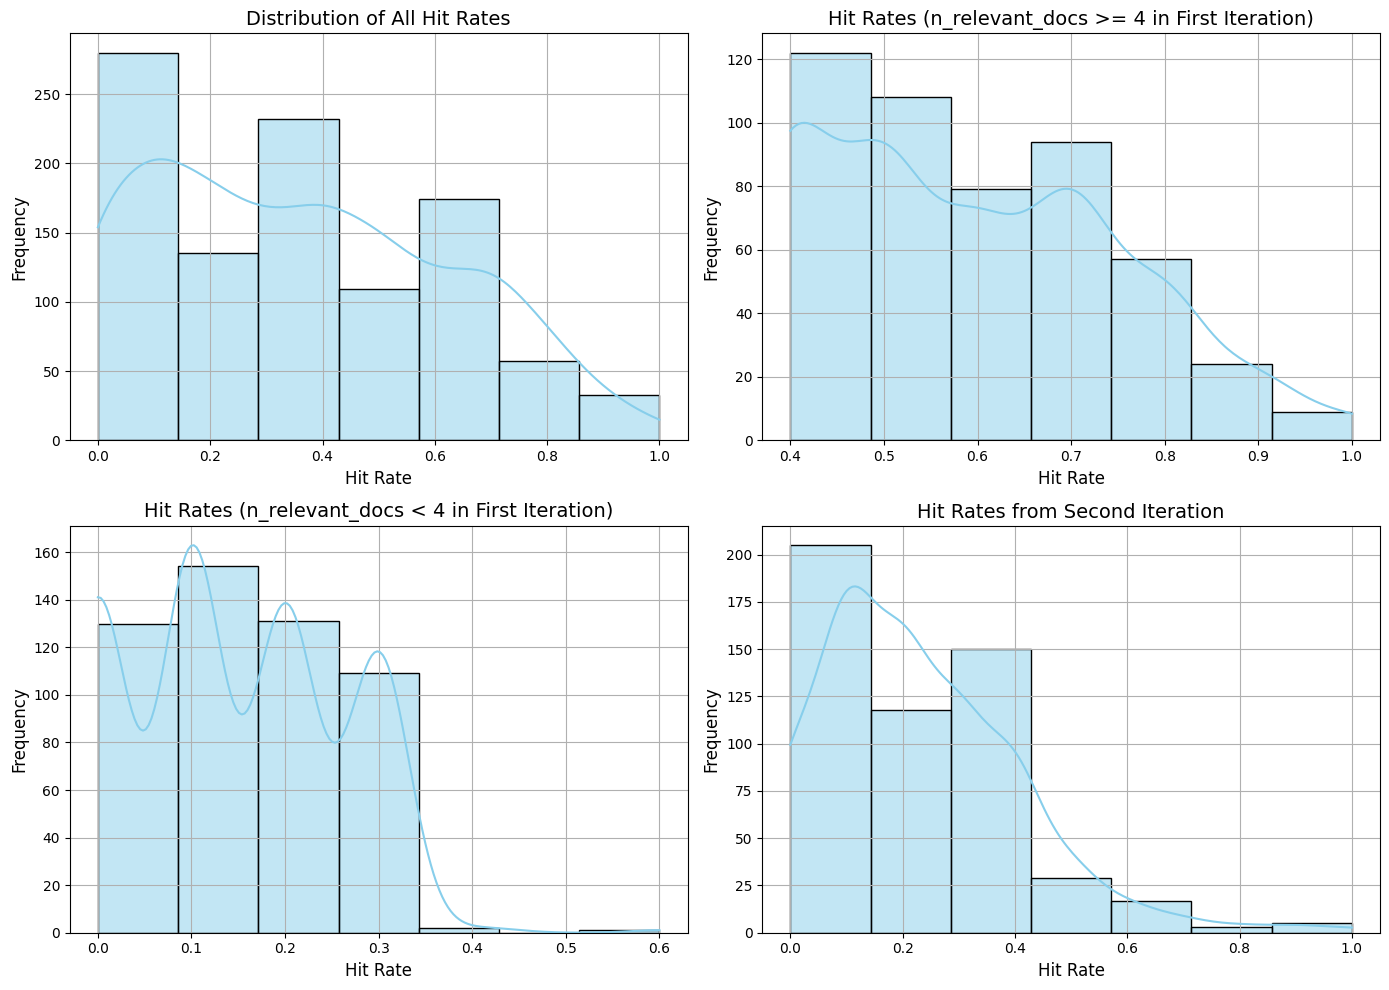

In [353]:
hit_rates_dict = {
    'all': hit_rates,
    'first_iteration_high': hit_rates_0,
    'first_iteration_low': hit_rates_1,
    'second_iteration': hit_rates_2,
}

plot_hit_rate_distributions(hit_rates_dict)

#### Answer Grader HITS
 No feedback needed (final_1) /  Total Cases analyzed

In [296]:
len(data['generate_final_answer_1']['question']) / len(data['generate_basic_1']['question'])

0.9313725490196079